# Завдання на використання SQL в Python

1.Встановіть бібліотеку `mysql-connector-python` через pip aбо через conda.

In [1]:
import mysql.connector
from mysql.connector.connection import MySQLConnection
import datetime

2.В змінній `con` створіть підключення до бази даних employees за аналогією того, як це робилось в лекції:

In [2]:
con = mysql.connector.connect(user='root', password='Qazxswedc123',
                              host='127.0.0.1',
                              database='employees')

3.Виберіть максимальну і мінімальну дати найму співробітників використовуючи `con.cursor()`. Аби отримати результати в кінці, виконайте `cursor.fetchall()`.

In [3]:
cursor = con.cursor()

sql = """
SELECT MAX(hire_date) AS max_date, MIN(hire_date) AS min_date
FROM employees
"""

cursor.execute(sql)

results = cursor.fetchall()

print(results)


[(datetime.date(2000, 1, 28), datetime.date(1985, 1, 1))]


Очікуваний результат:  
    `[(datetime.date(2000, 1, 28), datetime.date(1985, 1, 1))]`

In [4]:
cursor.close()

True

4.Давайте зберемо інформацію про останню ЗП кожного співробіткника в базі. З використанням `con.cursor()` виберіть з таблиці `salaries` для кожного співробітника його номер, останню в базі даних (тобто ту, що відповідає найновішій `to_date`) ЗП, та значення `from_date`, `to_date` для цієї ЗП.

Результати запишіть у pandas DataFrame, який збережіть у змінну `res`. Як взяти з курсора назви колонок - вже наведено. На екран виведіть назви колонок в змінній `res`, розмір цього датафрейму та перші 3 записи в ньому.

УВАГА! Зверніть увагу, що ЗП може оновлюватись протягом одного дня, тобто є випадки, коли апдейт ЗП був в певний день, скажімо 2001-01-01 і потім стався ще один апдейт ЗП цьому співробітнику цього самого дня. Запит має це враховувати.
Також, теоретично ЗП може бути зменшена. Тож, брати дату з максимальною ЗП буде неправильно з точки зору бізнес логіки. Треба саме останнє історичне значення ЗП кожного співробітника.

In [8]:
import pandas as pd

cursor = con.cursor()

sql = """
SELECT s.emp_no, s.salary, s.from_date, s.to_date
FROM salaries s
JOIN (
    SELECT emp_no, MAX(from_date) AS max_from_date, to_date
    FROM salaries
    WHERE to_date = (
        SELECT MAX(to_date)
        FROM salaries s2
        WHERE s2.emp_no = salaries.emp_no
    )
    GROUP BY emp_no, to_date
) latest
ON s.emp_no = latest.emp_no AND s.to_date = latest.to_date AND s.from_date = latest.max_from_date
ORDER BY s.emp_no;
"""

cursor.execute(sql)
results = cursor.fetchall()

columns = [desc[0] for desc in cursor.description]  
res = pd.DataFrame(results, columns=columns)

print(res.head(3))
print("Розмір датафрейму:", res.shape)

   emp_no  salary   from_date     to_date
0   10001   88958  2002-06-22  9999-01-01
1   10002   72527  2001-08-02  9999-01-01
2   10003   43311  2001-12-01  9999-01-01
Розмір датафрейму: (300024, 4)


In [ ]:
field_names = [i[0] for i in cursor.description]

Очікуваний результат:

![](https://drive.google.com/uc?export=view&id=1lNvzbAebtkj3C2v-I5AE6HkMH8MTI1kA)

5.В утвореній вибірці в змінній `res` скільки значень `to_date` рівні `9999-01-01`, а скільки - ні? Увага! Для виконання цього завдання важливо розуміти, який тип даних у значень колонки `to_date`. Зʼясуйте це, і потім напишіть фільтр для виводу потрібного результату.

In [20]:
print(res['to_date'].dtype)

object


In [21]:
res['to_date'] = res['to_date'].astype(str)
equal_9999 = (res['to_date'] == '9999-01-01').sum()
not_equal_9999 = (res['to_date'] != '9999-01-01').sum()

print(f"Кількість значень 'to_date', рівних 9999-01-01: {equal_9999}")
print(f"Кількість значень 'to_date', не рівних 9999-01-01: {not_equal_9999}")

Кількість значень 'to_date', рівних 9999-01-01: 240124
Кількість значень 'to_date', не рівних 9999-01-01: 59900


6.Виведіть візуально розподіл (гістограму) зарплат співробітників, які досі працюють в компанії, використовуючи результат попереднього завдання. Співробітниками, які досі працюють в компанії вважаємо тих, в кого to_date має значення 9999-01-01. Обовʼязково підпишіть графік і вісі.

Ці три завдання - приклад, як нам може бути зручно витягнути дані з бази певним запитом, а потім використати витягнуту вибірку у Python для подальшого аналізу.

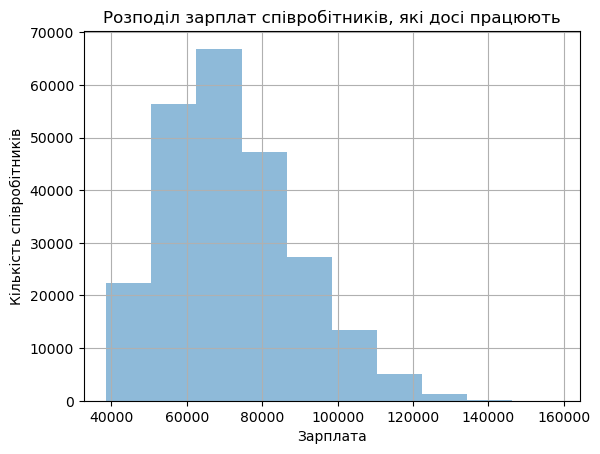

In [24]:
current_employees = res[res['to_date'] == '9999-01-01']

current_employees['salary'].plot(
    kind='hist', 
    bins=10, 
    alpha = .5, 
    title='Розподіл зарплат поточних співробітників',
    xlabel = 'Зарплата',
    ylabel = 'Кількість співробітників',
    grid = True);

Очікуваний результат:

![](https://drive.google.com/uc?export=view&id=1j8MHLC1E0revbQLM9B0UJs6tVEgoWhmK)

НЕ ЗАБУВАЄМО ЗАКРИТИ ПІДКЛЮЧЕННЯ ДО БАЗИ :)

In [25]:
con.close()